# Voting : 편함

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=10000)

# svm의 경우 soft 보팅이 실행 안됨 (확률예측 함수가 없음)
voting = VotingClassifier(estimators=[("KNN", knn), ("LR", lr)], voting = 'soft')

In [3]:
from sklearn.metrics import accuracy_score

knn.fit(X_train, y_train)
lr.fit(X_train, y_train)
voting.fit(X_train, y_train)
  
pred_knn = knn.predict(X_test)
pred_lr = lr.predict(X_test)
pred_vote = voting.predict(X_test)

print(accuracy_score(pred_knn, y_test))
print(accuracy_score(pred_lr, y_test))
print(accuracy_score(pred_vote, y_test))

0.9370629370629371
0.951048951048951
0.958041958041958


# Stacking : 마지막 정확도를 쥐어짜 올리자!

In [4]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=10000)
svc = SVC()
rf = RandomForestClassifier()

In [5]:
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print(knn.score(X_test, y_test))

lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print(lr.score(X_test, y_test))
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print(svc.score(X_test, y_test))

0.9370629370629371
0.951048951048951
0.9370629370629371


In [6]:
# 각 모델을 합치기
import numpy as np

# transpose() : 전치 함수 -> X_test와 일치하도록 해야 함
X_test_new = np.array([pred_knn, pred_lr, pred_svc]).transpose()
X_test_new.shape, X_test.shape

((143, 3), (143, 30))

In [7]:
from sklearn.metrics import accuracy_score

# 최종 모델로 학습하기
rf.fit(X_test_new, y_test)
pred_rf = rf.predict(X_test_new)
print(accuracy_score(pred_rf, y_test))

0.958041958041958


# Random  Forest

- 앙상블(ensemble)은 여러 머신러닝 모델을 연결하여 더 강력한 모델을 만드는 기법

- 머신러닝에는 이런 종류의 모델이 많지만, 랜덤 포레스트random forest와 그래디언트 부스팅(gradient boosting) 결정 트리는 둘 다 모델을 구성하는 기본 요소로 결정 트리를 사용

- 결정트리의 단점 : 과적합 문제

- 랜던 포레스트 : 타킷 예측을 잘하고 구별되는 어러 개의 트리를 만들기 위해 무작위성을 부여

- 랜덤 트리 생성 방법

  (1) 트리를 만들 때 사용하는 데이터 포인트를 무작위로 선택하는 방법
  
  (2) 분할 테스트에서 특성을 무작위로 선택하는 방법

## 랜덤 포레스트 만들기
- 랜덤 포레스트 모델을 만들려면 생성할 트리의 개수를 정해야 함 (RandomForestRegressor나 RandomForestClassifier의 n_estimators 매개변수)

  ><b>(1) 트리를 만들기 위해 먼저 데이터의 부트스트랩 샘플bootstrap sample을 생성</b> (n_samples개의 데이터 포인트 중에서 무작위로 데이터를 n_samples 횟수만큼 반복 추출)

- 부스스트랩 샘플의 예 ( [‘a’, ‘b’, ‘c’, ‘d’]에서 부트스트랩 샘플을 만든다고 하면)

   [‘b’, ‘d’, ‘d’, ‘c’] ,  [‘d’, ‘a’, ‘d’, ‘a’], [‘a’, ‘a’, ‘c’, ‘b’] 등

  ><b>(2) 생성한 데이터 셋으로 트리를 만듬</b>

- 전체 데이터 셋 대상이 아닌 무작위로 선택한 데이터 셋 중에서 최선의 데이터 셋을 찾음
- <font color=red>몇 개의 특성을 고를 지 선택 -> max_features</font>
- <font color=red>몇 개의 트리를 만들 지 선택 -> n_estimators</font>
-  max_features=1로 설정하면 트리의 분기는 테스트할 특성을 고를 필요가 없게 되며 무작위로 선택한 특성의 임계값을 찾기만 하면 됨

- max_features 값을 크게 하면 랜덤 포레스트의 트리들은 매우 비슷해지고 가장 두드러진 특성을 이용해 데이터에 잘 맞춰질 것

- max_features를 낮추면 랜덤 포레스트 트리들은 많이 달라지고 각 트리는 데이터에 맞추기 위해 깊이가 깊어지게 됨

  ><b>(3) 모델에 있는 모든 트리의 예측을 만듬</b>
-  회귀의 경우에는 이 예측들을 평균하여 최종 예측을 만듬
- 분류의 경우는 약한 투표 전략을 사용 -> 각 알고리즘은 가능성 있는 출력 레이블의 확률을 제공함으로써 간접적인 예측하고 트리들이 예측한 확률을 평균내어 가장 높은 확률을 가진 클래스가 예측값이 됨

## 유방암 데이터를 이용한 학습

- 유방암 데이터셋에 100개의 트리로 이뤄진 랜덤 포레스트를 적용

In [8]:
import warnings

warnings.filterwarnings("ignore")

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=66)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.979


- 랜덤 포레스트는 아무런 매개변수 튜닝 없이도 선형 모델이나 단일 결정 트리보다 높은 97% 정확도를 냄

- 단일 결정 트리에서 한 것처럼 max_features 매개변수를 조정하거나 사전 가지치기를 할 수도 있음

# AdaBoost (Adaptive Boosting)

- GradientBoosting 처럼 약한 학습기를 사용
- 다른 점은 이전의 모델이 잘못 분류한 샘플에 가중치를 높여서 다음 모델을 훈련시킴
- 훈련된 각 모델은 성능에 따라 가중치가 부여됨
- 예측을 만들 때는 모델이 예측된 레이블을 기준으로 모델의 가중치를 합산하여 가장 높은 값을 가진 레이블을 선택

- GradientBoosting와 마찬가지로 순차적으로 학습해야 하므로 n_jobs 매개변수는 지원하지 않음

In [10]:
from sklearn.ensemble import AdaBoostClassifier

bagging_adb = AdaBoostClassifier(n_estimators=5, random_state=42)
bagging_adb.fit(X_train, y_train)

print("훈련 세트 정확도 : {:.3f}".format(bagging_adb.score(X_train, y_train)))
print("테스트 세트 정확도 : {:.3f}".format(bagging_adb.score(X_test, y_test)))

훈련 세트 정확도 : 0.962
테스트 세트 정확도 : 0.972


- AdaBoostCalssifier는 깊이가 1인 결정트리를 사용하므로 각 트리의 결정 경계가 직선 하나 뿐임.

- 유방암 데이터를 이용

In [11]:
from sklearn.ensemble import AdaBoostClassifier

bagging_adb2 = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging_adb2.fit(X_train, y_train)

print("훈련 세트 정확도 : {:.3f}".format(bagging_adb2.score(X_train, y_train)))
print("테스트 세트 정확도 : {:.3f}".format(bagging_adb2.score(X_test, y_test)))

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.986


# GradientBoosting 

- 여러 개의 결정 트리를 묶어 강력한 모델을 만드는앙상블 방법

- 회귀와 분류 모두에 사용

- 랜덤 포레스트와는 달리 그래디언트 부스팅은 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듬 (무작위성이 없음)

- 강력한 사전 가지치기가 사용

- 보통 다섯 개 이하 깊이의 트리를 사용하므로 메모리를 적게 사용하고 예측도 빠름

- 각각의 트리는 데이터의 일부에 대해서만 예측을 잘 수행할 수 있어서 트리가 많이 추가될수록 성능이 좋아짐

-  랜덤 포레스트보다는 매개변수 설정에 조금 더 민감하지만 잘 조정하면 더 높은 정확도를 제공

-  learning_rate : 이전 트리의 오차를 얼마나 강하게 보정할 것인지를 제어

- 학습률이 크면 트리는 보정을 강하게 하기 때문에 복잡한 모델을 만듬

- n_estimators 값을 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 훈련 세트에서의 실수를 바로잡을 기회가 더 많아짐

## 유방암 데이터 적용

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt1 = GradientBoostingClassifier(random_state=0)
gbrt1.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt1.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt1.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.958


- 훈련 세트의 정확도가 100%이므로 과대적합
- 과대적합을 막기 위해서 트리의 최대 깊이를 줄여 사전 가지치기를 강하게 하거나 학습률을 낮출 수 있음

In [13]:
gbrt2 = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt2.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt2.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt2.score(X_test, y_test)))

훈련 세트 정확도: 0.993
테스트 세트 정확도: 0.979


- 학습률을 조정한 경우

In [14]:
gbrt3 = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt3.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt3.score(X_train, y_train)))
print("훈련 세트 정확도: {:.3f}".format(gbrt3.score(X_test, y_test)))

훈련 세트 정확도: 0.984
훈련 세트 정확도: 0.937


- 두 방식은 모델의 복잡도를 감소시키므로 예상대로 훈련 세트의 정확도가 낮아짐
- 학습률을 낮추는 것은 테스트 세트의 성능을 조금밖에 개선하지 못했지만, 트리의 최대 깊이를 낮추는 것은 모델 성능 향상에 크게 기여

## 장단점

- 지도 학습에서 가장 강력하고 널리 사용하는 모델 중 하나

- 가장 큰 단점은 매개변수를 잘 조정해야 한다는 것과 훈련 시간이 길다는 것

- 다른 트리 기반 모델처럼 특성의 스케일을 조정하지 않아도 되고 이진 특성이나 연속적인 특성에서도 잘 동작

- 트리 기반 모델의 특성상 희소한 고차원 데이터에는 잘 작동하지 않음

- 중요 매개변수 : 트리의 개수를 지정하는 <font color=red>n_estimators</font>, 이전 트리의 오차를 보정하는 정도를 조절하는 <font color=red>learning_rate</font>

- 두 매개변수는 깊게 연관되며 learning_rate를 낮추면 비슷한 복잡도의 모델을 만들기 위해서 더 많은 트리를 추가해야 함

- n_estimators가 클수록 좋은 랜덤 포레스트와는 달리 그래디언트 부스팅에서 n_estimators를 크게 하면 모델이 복잡해지고 과대적합될 가능성이 높아짐

- 일반적인 관례는 가용한 시간과 메모리 한도에서 n_estimators를 맞추고 나서 적절한 learning_rate를 찾는 것

- 중요한 또 다른 매개변수는 각 트리의 복잡도를 낮추는 <font color=red>max_depth</font>(또는 <font color=red>max_leaf_nodes</font>)

- 일반적으로 그래디언트 부스팅 모델에서는 max_depth를 매우 작게 설정하며 트리의 깊이가 5보다 깊어지지 않게 함.

#Xgboost

In [15]:
!pip install xgboost

In [16]:
import xgboost
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(random_state=0, max_depth=1)
xgb.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(xgb.score(X_train, y_train)))
print("훈련 세트 정확도: {:.3f}".format(xgb.score(X_test, y_test)))

훈련 세트 정확도: 1.000
훈련 세트 정확도: 0.965


# Light GBM
- XG Boosting에 비해 가볍고(Low memory) 빠르며 정확도가 높은 모델
- Leaf-wise(수직방향, 비대칭)로 트리를 성장시킴(속도↑)
   - Level-wise(수평방향, 깊이↓, 대칭)보다 오류가 더 적음(정확도↑) 
     
- 대량(1만개 이상)의 데이터를 병렬로 빠르게 학습가능(Low Memory, GPU활용 가능)
   → XG Boosting 대비 2~10배의 속도(동일 파라미터 설정 시)
   → 소량의 데이터에서는 제대로 동작하지 않음(과대적합 위험)
- 예측 속도가 빠름 (Leaf-wise 트리의 장점)
   → 그러나 Level-wise에 비해 과적합에 민감

In [17]:
!pip install lightgbm

In [18]:
import lightgbm as lgb

# 트레이닝 데이터를 LightGBM에 맞는 데이터 세트 포맷으로 변환
# LightGBM 트레이닝에 있어서 필수적
# 모델의 정확도는 설정된 파라미터 값에 전적으로 달려 있음
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
# rf (랜덤포레스트), dart, goss
params['boosting_type'] = 'gbdt' 
# 이진분류 : 초기값은 회귀 분석 (regression (회귀), multiclass (다중 분류))
params['objective'] = 'binary'
# mae, mse, multi_logloss
params['metric'] = 'binary_logloss'
# 특성 비율
params['sub_feature'] = 0.5
# 2^max_depth보다 작아야 한다
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

# 훈련
clf = lgb.train(params, d_train, 100)

[LightGBM] [Info] Number of positive: 265, number of negative: 161
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4272
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622066 -> initscore=0.498325
[LightGBM] [Info] Start training from score 0.498325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [19]:
# 예측
y_pred = clf.predict(X_test)

# 이진 값으로 변환
for i in range(0, y_pred.shape[0]):
    if y_pred[i]>=.5:       
        y_pred[i]=1
    else:  
        y_pred[i]=0

In [20]:
from sklearn.metrics import accuracy_score
 
accuracy = accuracy_score(y_pred, y_test)

accuracy

0.8881118881118881

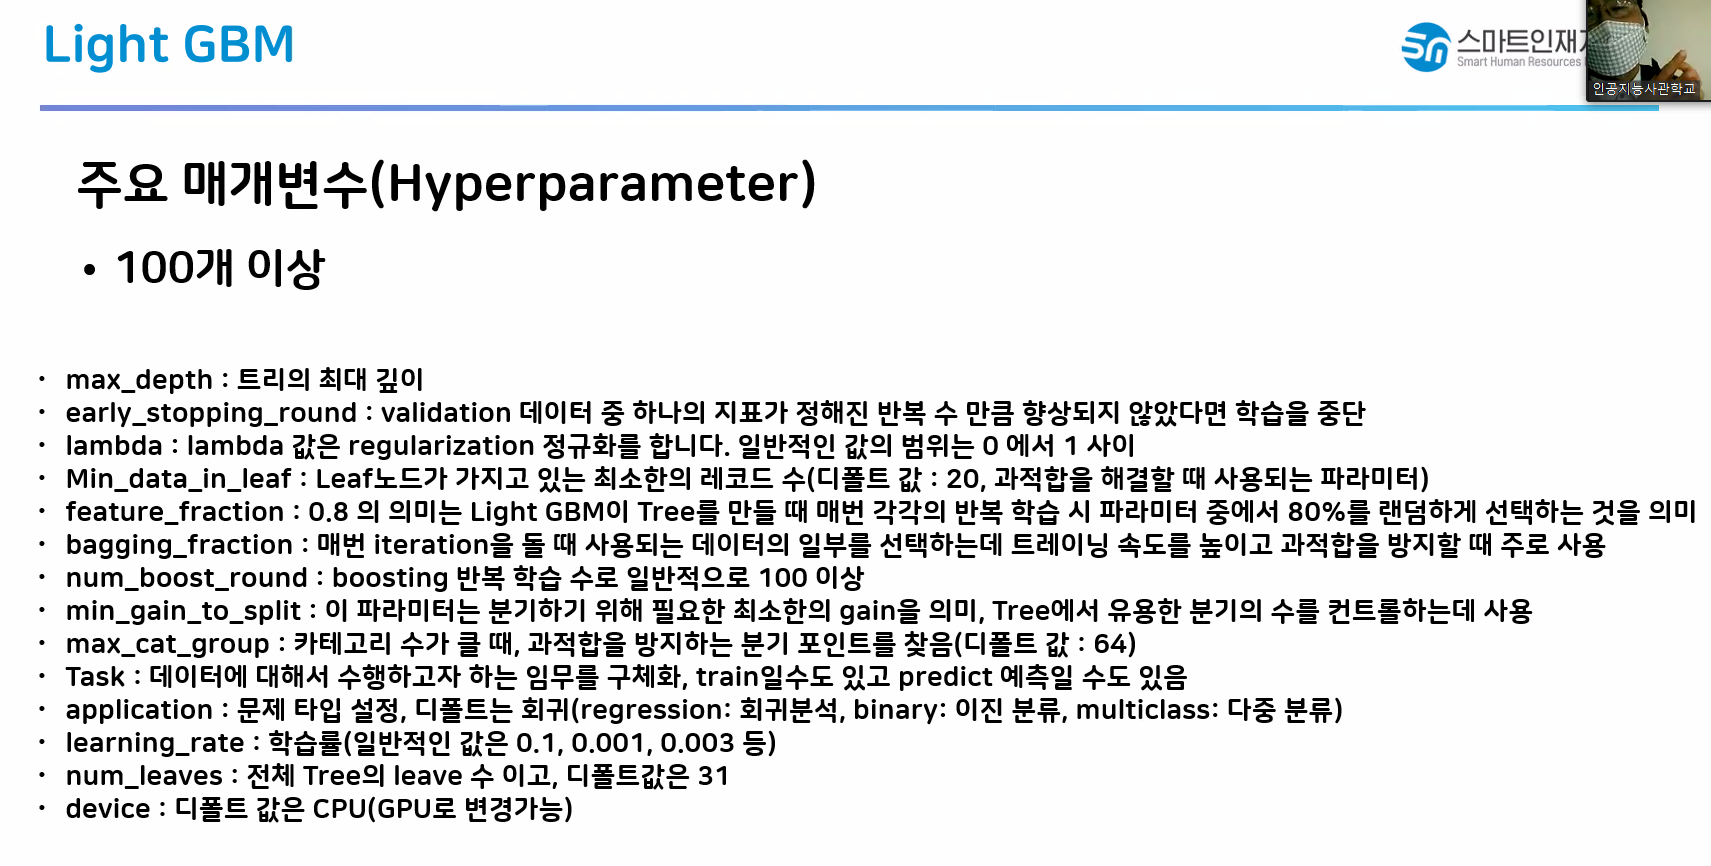
- 더 빠른 속도 
  - bagging_fraction
  - max_bin은 작게
  - save_binary 사용
  - parallel learning 사용

- 더 높은 정확도
  - max_bin 크게
  - num_iterations 크게, learing_rate 작게
  - num_leaves 크게 (과적합 발생)
  - boosting 알고리즘을 dart 사용
- 과적합 줄이기
  - max_bin 작게
  - num_leaves 작게
  - min_data_in_leaf와 min_sum_hessian_in_leaf 사용  

# CatBoost

In [21]:
!pip install catboost

In [22]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=10)

catboost.fit(X_train, y_train)

Learning rate set to 0.488306
0:	learn: 0.2060044	total: 179ms	remaining: 1.61s
1:	learn: 0.1129357	total: 182ms	remaining: 729ms
2:	learn: 0.0735976	total: 186ms	remaining: 433ms
3:	learn: 0.0542849	total: 190ms	remaining: 285ms
4:	learn: 0.0432583	total: 194ms	remaining: 194ms
5:	learn: 0.0329219	total: 197ms	remaining: 132ms
6:	learn: 0.0283931	total: 200ms	remaining: 85.8ms
7:	learn: 0.0214081	total: 205ms	remaining: 51.4ms
8:	learn: 0.0184961	total: 210ms	remaining: 23.3ms
9:	learn: 0.0173784	total: 215ms	remaining: 0us


In [23]:
# 예측
y_pred = catboost.predict(X_test)

# 이진 값으로 변환
for i in range(0, y_pred.shape[0]):
    if y_pred[i]>=.5:       
        y_pred[i]=1
    else:  
        y_pred[i]=0

In [24]:
from sklearn.metrics import accuracy_score
 
accuracy = accuracy_score(y_pred, y_test)

accuracy

0.965034965034965

# Hyperparameter Tuning

- 매개변수을 선택하는 것은 머신러닝에서 중요한 일

- GridSearch : 관심 있는 매개변수들을 대상으로 가능한 모든 조합 시도하는 것
- RandomSearch : 임의의 매개변수를 값들을 대상으로 조합을 시도하는 것
- Bayesian Optimization : 임의의 매개변수를 값들을 대상으로 최적의 조합을 찾는 것

## GridSearch

- GridSearch 기능과 교차검증을 동시에 수행

In [25]:
# 딕셔너리 형태로 파라미터의 값들을 설정
param_grid = {"n_estimators": range(1, 100, 5),
              "max_features": range(1, 30, 3)}

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# return_train_score : 훈련 폴드(cv)의 점수를 받을지 여부를 설정
# scoring : 분류 (accuracy, f1), 회귀 (neg_mean_squared_error, r2)
# n_jobs : 병렬처리 수 (CPU 코어 수가 충분하다면 설정, 디폴트 1) - 내부적으로 멀티프로세스 동작 -> 속도 증가
#grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True, scoring='f1_micro', n_jobs=2)
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 30, 3),
                         'n_estimators': range(1, 100, 5)})

- GridSearchCV 객체에 fit() 매서드는 최적의 매개변수를 찾는 일 뿐만 아니라 교차 검증 성능이 가장 좋은 매개변수로 전체 훈련 데이터 세트에 대해 새로운 모델을 자동을 만듬

- GridSearchCV는 전체 데이터로 학습한 모델에 접근할 수 있도록 predict()와 score() 메서드 제공

- GridSearchCV 분류 : StratifiedKFold 회귀 : KFold

- 사용에 따라서는 predict_proba, decision_function도 제공

In [27]:
print("테스트 세트 점수: {:.2f}".format(grid_search.score(X_test, y_test)))

테스트 세트 점수: 0.97


In [28]:
print("최적 매개변수: {}".format(grid_search.best_params_))
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))
print("최고 성능 모델:\n{}".format(grid_search.best_estimator_))

최적 매개변수: {'max_features': 10, 'n_estimators': 36}
최고 교차 검증 점수: 0.96
최고 성능 모델:
RandomForestClassifier(max_features=10, n_estimators=36)


- 최적 매개 변수에서 전체 훈련 세트를 사용하여 학습한 모델은 best_estimator_

- grid_search 객체가 predict와 score 메서드를 가지고 있으므로 예측이나 모델을 평가하기 위해 best_estimator_ 속성을 사용할 필요가 없다.

## RandomSearch

In [29]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                   param_grid, 
                                   random_state=0,
                                   cv=5)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_features': range(1, 30, 3),
                                        'n_estimators': range(1, 100, 5)},
                   random_state=0)

In [30]:
print("테스트 세트 점수: {:.2f}".format(random_search.score(X_test, y_test)))

테스트 세트 점수: 0.98


In [31]:
print("최적 매개변수: {}".format(random_search.best_params_))
print("최고 교차 검증 점수: {:.2f}".format(random_search.best_score_))
print("최고 성능 모델:\n{}".format(random_search.best_estimator_))

최적 매개변수: {'n_estimators': 61, 'max_features': 1}
최고 교차 검증 점수: 0.96
최고 성능 모델:
RandomForestClassifier(max_features=1, n_estimators=61)


## Bayesian Optimization

In [32]:
!pip install scikit-optimize

In [33]:
# 시작값과 끝값을 설정
param_grid = {"n_estimators": (1, 100),
              "max_features": (1, 30)}

In [34]:
from skopt import BayesSearchCV
import warnings

warnings.filterwarnings('ignore')

bayes_search = BayesSearchCV(RandomForestClassifier(), 
                             param_grid, 
                             random_state=0,
                             cv=5)

bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=0,
              search_spaces={'max_features': (1, 30), 'n_estimators': (1, 100)})

In [35]:
print("테스트 세트 점수: {:.2f}".format(bayes_search.score(X_test, y_test)))

테스트 세트 점수: 0.97


In [36]:
print("최적 매개변수: {}".format(bayes_search.best_params_))
print("최고 교차 검증 점수: {:.2f}".format(bayes_search.best_score_))
print("최고 성능 모델:\n{}".format(bayes_search.best_estimator_))

최적 매개변수: OrderedDict([('max_features', 10), ('n_estimators', 100)])
최고 교차 검증 점수: 0.96
최고 성능 모델:
RandomForestClassifier(max_features=10)


# 특징 선택 (Feature Selection)

- 특성의 수가 많아지면 모델이 복잡해지고 과대적합이 될 가능성이 높아짐

### 일변량 통계 

- 특성과 라벨 사이의 통계적 관계를 분석하여 관계가 깊은 것만 선택

- SelectKBest : 고정된 k개의 특성을 선택

- SelectPercentile : 지정된 비율만큼 특성을 선택


In [37]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif

# SelectKBest의 k는 선택할 특성의 수를 지정
select = SelectKBest(score_func=f_classif, k=10)
select.fit(X_train, y_train)

SelectKBest()

In [38]:
# 선택한 특성 표시
mask = select.get_support()
cancer.feature_names[mask==True]

array(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'worst radius', 'worst perimeter',
       'worst area', 'worst concavity', 'worst concave points'],
      dtype='<U23')

In [39]:
# 선택한 특성으로 된 데이터를 저장
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

In [40]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.001)
lr.fit(X_train, y_train)

print("테스트 점수 (전체 특성): {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("테스트 점수 (일부 선택): {:.3f}".format(lr.score(X_test_selected, y_test)))

테스트 점수 (전체 특성): 0.916
테스트 점수 (일부 선택): 0.909


In [41]:
# f_classif(기본값)와 SelectPercentile을 사용하여 특성의 50%를 선택
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)

SelectPercentile(percentile=50)

In [42]:
# 선택한 특성 표시
mask = select.get_support()
cancer.feature_names[mask==True]

array(['mean radius', 'mean perimeter', 'mean area', 'mean compactness',
       'mean concavity', 'mean concave points', 'radius error',
       'perimeter error', 'area error', 'worst radius', 'worst perimeter',
       'worst area', 'worst compactness', 'worst concavity',
       'worst concave points'], dtype='<U23')

In [43]:
# 선택한 특성으로 된 데이터를 저장
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

In [44]:
lr = LogisticRegression(C=0.001)
lr.fit(X_train, y_train)

print("테스트 점수 (전체 특성): {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("테스트 점수 (일부 선택): {:.3f}".format(lr.score(X_test_selected, y_test)))

테스트 점수 (전체 특성): 0.916
테스트 점수 (일부 선택): 0.909


### 모델 기반 특성 선택

- 지도 학습 모델로 계산된 중요도가 지정한 임계치보다 큰 모든 특성을 선택

- 일변량 모델보다 훨씬 강력한 성능을 제공

In [45]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# 특성 선택 설정
# threshold="median" : 중간값을 임계치로 설정
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

In [46]:
# 특성 선택
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

In [47]:
# 선택한 특성 표시
mask = select.get_support()
cancer.feature_names[mask==True]

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean concavity', 'mean concave points', 'radius error',
       'area error', 'worst radius', 'worst texture', 'worst perimeter',
       'worst area', 'worst compactness', 'worst concavity',
       'worst concave points'], dtype='<U23')

In [48]:
# 모델에 적용
lr = LogisticRegression(C=0.001)
lr.fit(X_train, y_train)

print("테스트 점수 (전체 특성): {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("테스트 점수 (일부 선택): {:.3f}".format(lr.score(X_test_selected, y_test)))

테스트 점수 (전체 특성): 0.916
테스트 점수 (일부 선택): 0.923


### 반복적 특성 선택

- 모든 특성으로 시작해서 반복적으로 특성 중요도가 낮은 특성을 제거

In [49]:
from sklearn.feature_selection import RFE

# n_features_to_select : 선택할 특성의 수
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=10)

select.fit(X_train, y_train)

# 특성 선택
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

In [50]:
# 선택한 특성 표시
mask = select.get_support()
cancer.feature_names[mask==True]

array(['mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'area error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area',
       'worst concave points'], dtype='<U23')

In [51]:
# 모델에 적용
lr = LogisticRegression(C=0.001)
lr.fit(X_train, y_train)

print("테스트 점수 (전체 특성): {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("테스트 점수 (일부 선택): {:.3f}".format(lr.score(X_test_selected, y_test)))

테스트 점수 (전체 특성): 0.916
테스트 점수 (일부 선택): 0.923
